In [ ]:
import os
from pathlib import Path
import logging
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set up logging and CSV export directories
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = Path("performance/filter/logs")
csv_dir = Path("performance/filter/csv_exports")
log_dir.mkdir(parents=True, exist_ok=True)
csv_dir.mkdir(parents=True, exist_ok=True)

log_file = log_dir / f"filter_analysis_{timestamp}.log"

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(),  # Also log to console
    ],
)

logger = logging.getLogger(__name__)
logger.info(f"Starting filter performance analysis - Log file: {log_file}")
logger.info(f"CSV exports will be saved to: {csv_dir}")

# Get list of all CSV files in the directory
list_of_files = list(Path("../../logs/performance_filters_fainder").rglob("*.csv"))
logger.info(f"Processing {len(list_of_files)} CSV files")

# Load in all files in df
df_latest = pd.DataFrame()
for file in list_of_files:
    temp_df = pd.read_csv(file)
    df_latest = pd.concat([df_latest, temp_df], ignore_index=True)

logger.info(f"Loaded {len(df_latest)} total records")
logger.info(f"Unique fainder modes: {list(df_latest['fainder_mode'].unique())}")

# Save processed data to CSV
processed_data_file = csv_dir / f"processed_data_{timestamp}.csv"
df_latest.to_csv(processed_data_file, index=False)
logger.info(f"Saved processed data to: {processed_data_file}")

os.makedirs("performance/filter", exist_ok=True)

# "timestamp","percentile", "comparison","reference","fainder_mode","execution_time","filter_size_right","filter_size_wrong","filter_size","num_results","num_results_without_filter","query","num_workers",
print("Data loaded successfully!")
print(f"Shape: {df_latest.shape}")
print(f"Columns: {list(df_latest.columns)}")
print(df_latest.head())

# change num_workers 1 to 0
df_latest["num_workers"] = df_latest["num_workers"].replace(1, 0)

2025-07-20 12:38:06,980 - INFO - Starting filter performance analysis - Log file: performance/filter/logs/filter_analysis_20250720_123806.log
2025-07-20 12:38:06,981 - INFO - CSV exports will be saved to: performance/filter/csv_exports
2025-07-20 12:38:06,982 - INFO - Processing 4 CSV files
2025-07-20 12:38:06,981 - INFO - CSV exports will be saved to: performance/filter/csv_exports
2025-07-20 12:38:06,982 - INFO - Processing 4 CSV files
2025-07-20 12:38:07,001 - INFO - Loaded 10320 total records
2025-07-20 12:38:07,002 - INFO - Unique fainder modes: ['full_precision', 'exact']
2025-07-20 12:38:07,001 - INFO - Loaded 10320 total records
2025-07-20 12:38:07,002 - INFO - Unique fainder modes: ['full_precision', 'exact']
2025-07-20 12:38:07,044 - INFO - Saved processed data to: performance/filter/csv_exports/processed_data_20250720_123806.csv
2025-07-20 12:38:07,044 - INFO - Saved processed data to: performance/filter/csv_exports/processed_data_20250720_123806.csv


Data loaded successfully!
Shape: (10320, 13)
Columns: ['timestamp', 'percentile', 'comparison', 'reference', 'fainder_mode', 'execution_time', 'filter_size_right', 'filter_size_wrong', 'filter_size', 'num_results', 'num_results_without_filter', 'query', 'num_workers']
             timestamp  percentile comparison  reference    fainder_mode  \
0  2025-07-19 22:43:08         0.1         le          1  full_precision   
1  2025-07-19 22:43:13         0.1         le          1  full_precision   
2  2025-07-19 22:43:18         0.1         le          1  full_precision   
3  2025-07-19 22:43:24         0.1         le          1  full_precision   
4  2025-07-19 22:43:29         0.1         le          1  full_precision   

   execution_time  filter_size_right  filter_size_wrong  filter_size  \
0        0.012911                  0                  0            0   
1        0.039216                100                  0          100   
2        0.037821                100               1000   

2025-07-20 12:38:07,063 - INFO - === Filter Ratio Analysis ===
2025-07-20 12:38:07,069 - INFO - Found 10080 records with right filters for ratio analysis
2025-07-20 12:38:07,075 - INFO - Baseline times: fainder_mode    num_workers
exact           0              13.277285
                5               3.354145
                11              2.041161
                27              1.360038
full_precision  0               0.012196
                5               0.011072
                11              0.011110
                27              0.010690
Name: execution_time, dtype: float64
2025-07-20 12:38:07,194 - INFO - Analyzing filter ratios for fainder mode: full_precision
/tmp/ipykernel_11746/2030986243.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab10", len(filter_size_c

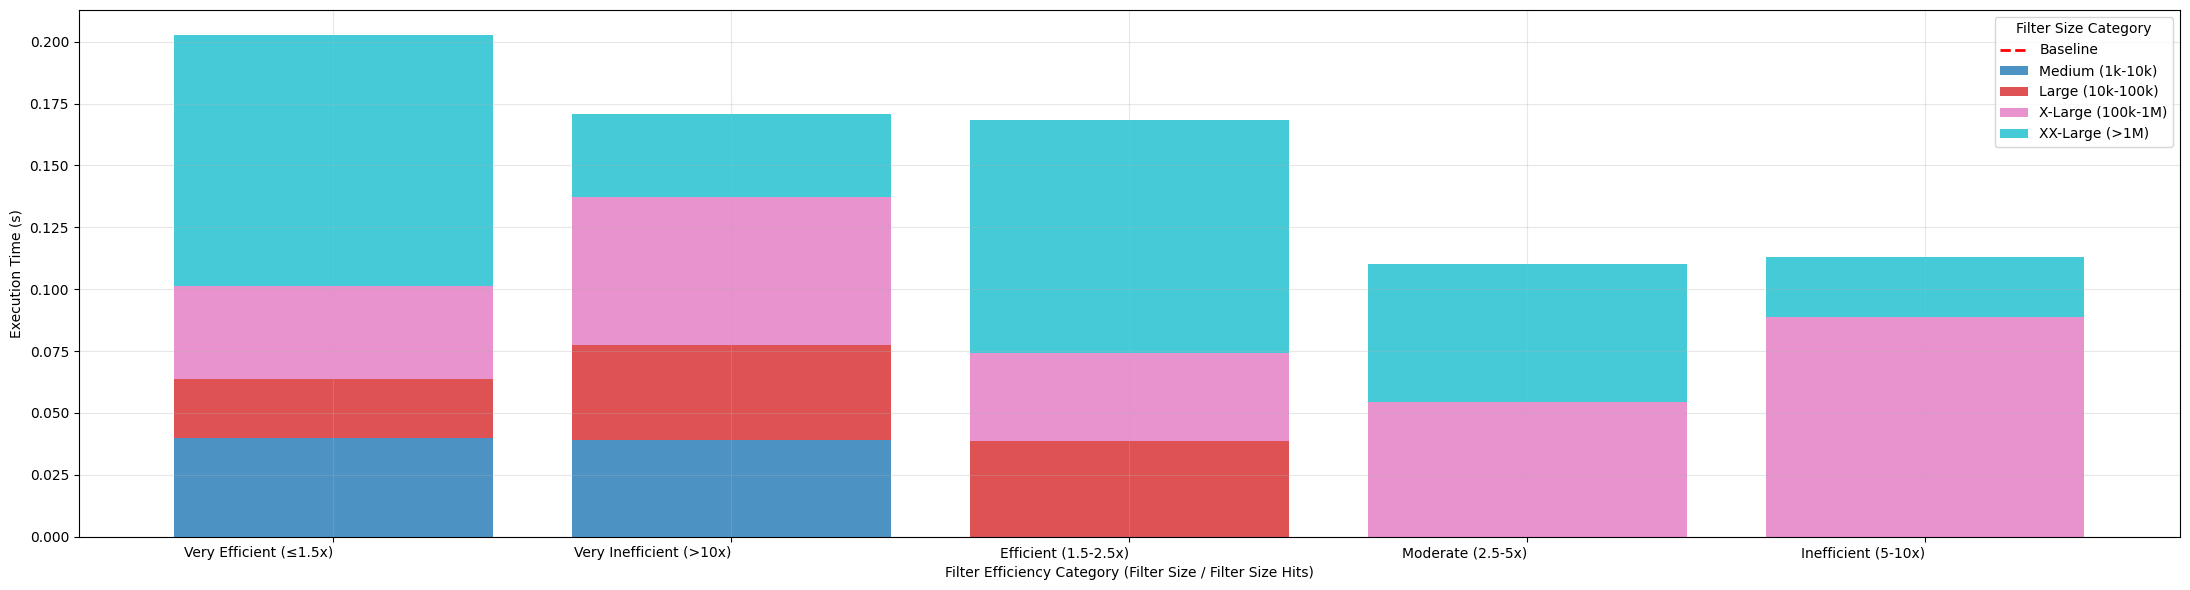

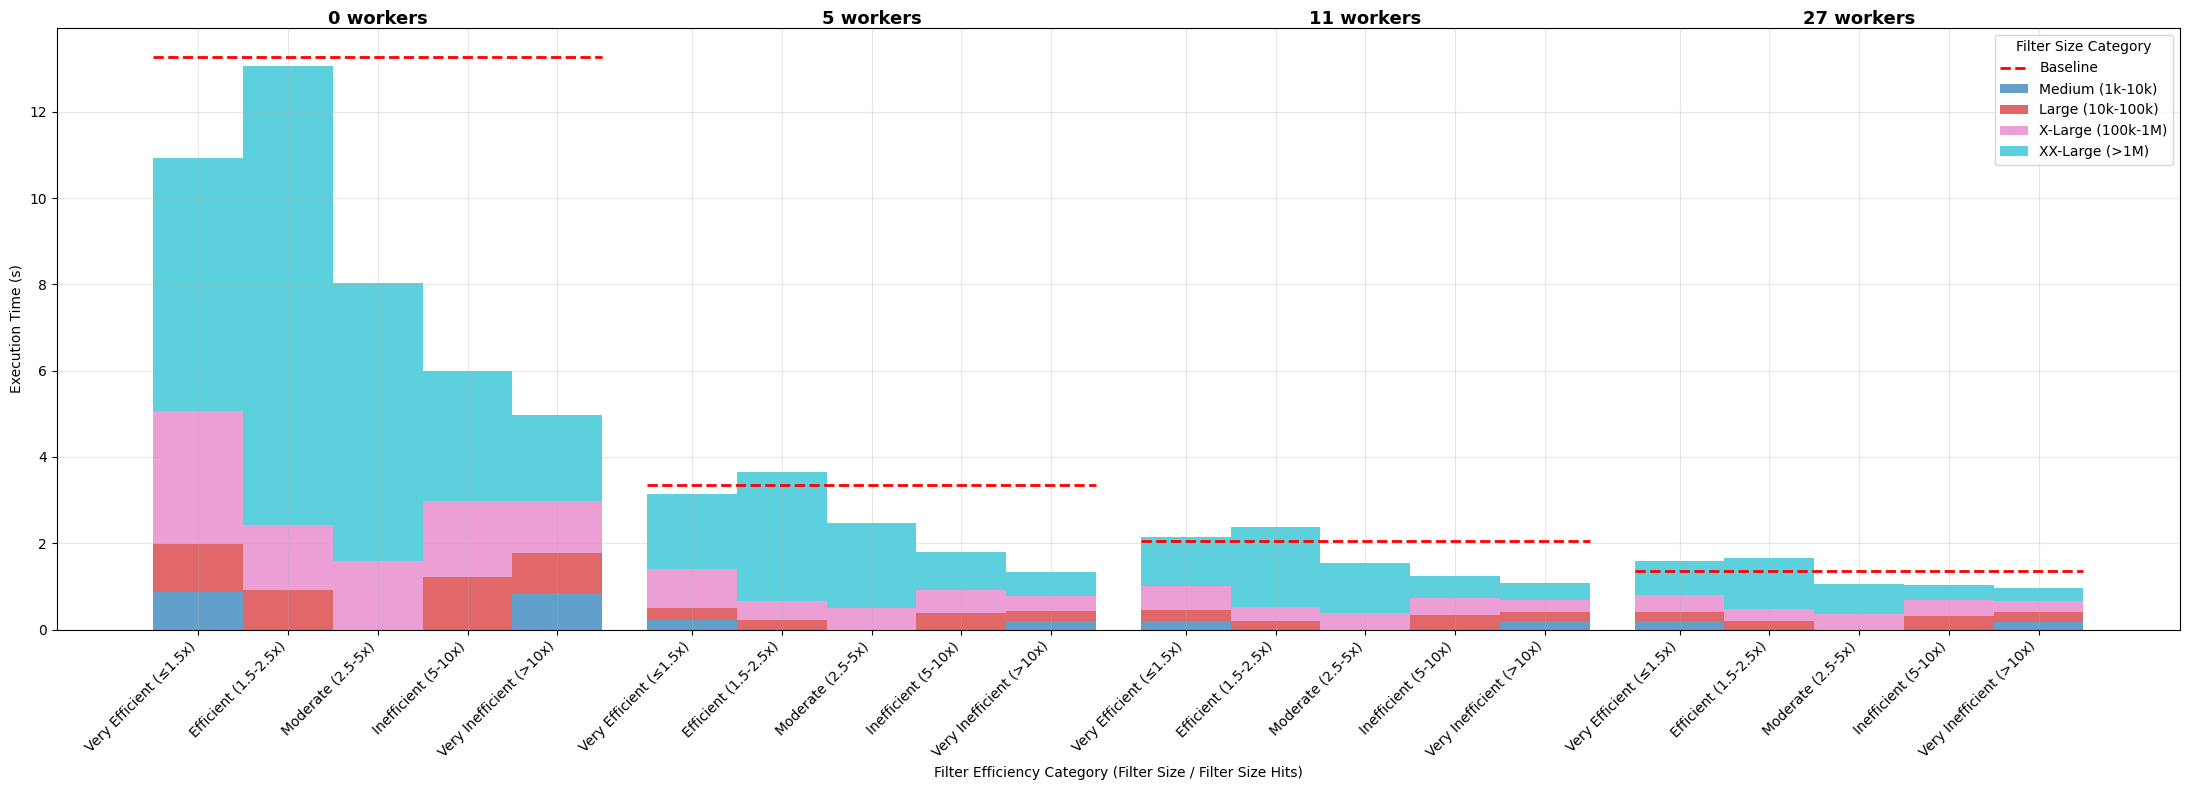

In [146]:
# ========================================
# FILTER RATIO ANALYSIS
# ========================================
logger.info("=== Filter Ratio Analysis ===")

# Filter for cases where we have right filters (meaningful ratio calculation)
df_ratio_analysis = df_latest[df_latest["filter_size_right"] > 0].copy()
logger.info(
    f"Found {len(df_ratio_analysis)} records with right filters for ratio analysis"
)

# Calculate filter ratio and categorize
df_ratio_analysis["filter_ratio"] = (
    df_ratio_analysis["filter_size"] / df_ratio_analysis["filter_size_right"]
)
df_ratio_analysis["filter_efficiency"] = (
    df_ratio_analysis["filter_size_right"] / df_ratio_analysis["filter_size"]
)

# Create filter ratio categories
df_ratio_analysis["filter_ratio_category"] = pd.cut(
    df_ratio_analysis["filter_ratio"],
    bins=[0, 1.5, 2.5, 5.0, 10.0, float("inf")],
    labels=[
        "Very Efficient (≤1.5x)",
        "Efficient (1.5-2.5x)",
        "Moderate (2.5-5x)",
        "Inefficient (5-10x)",
        "Very Inefficient (>10x)",
    ],
)

# create filter size category
df_ratio_analysis["filter_size_category"] = pd.cut(
    df_ratio_analysis["filter_size"],
    bins=[100, 1000, 10000, 100000, 1000000, float("inf")],
    labels=[
        "Small (100-1k)",
        "Medium (1k-10k)",
        "Large (10k-100k)",
        "X-Large (100k-1M)",
        "XX-Large (>1M)",
    ],
)

# Calculate baseline times and speedup
baseline_times = (
    df_latest[df_latest["filter_size"] == 0]
    .groupby(["fainder_mode", "num_workers"])["execution_time"]
    .mean()
)
logger.info(f"Baseline times: {baseline_times}")

df_ratio_analysis["baseline_time"] = df_ratio_analysis.apply(
    lambda row: baseline_times.get((row["fainder_mode"], row["num_workers"]), 0), axis=1
)

df_ratio_analysis["speedup"] = (
    df_ratio_analysis["baseline_time"] / df_ratio_analysis["execution_time"]
)

# Analyze each fainder mode
for fainder_mode in df_ratio_analysis["fainder_mode"].unique():
    if fainder_mode == "exact":
        logger.info(f"Analyzing filter ratios for fainder mode: {fainder_mode}")
        df_mode = df_ratio_analysis[df_ratio_analysis["fainder_mode"] == fainder_mode]

        # Sort workers and filter ratio categories for consistent plotting
        workers = sorted(df_mode["num_workers"].unique())
        filter_ratio_categories = [
            cat
            for cat in df_mode["filter_ratio_category"].cat.categories
            if cat in df_mode["filter_ratio_category"].unique()
        ]
        filter_size_categories = [
            cat
            for cat in df_mode["filter_size_category"].cat.categories
            if cat in df_mode["filter_size_category"].unique()
        ]

        n_workers = len(workers)
        n_ratio = len(filter_ratio_categories)
        width = 1  # width of each bar

        # Assign a color for each filter_size_category
        import matplotlib.cm as cm

        color_map = cm.get_cmap("tab10", len(filter_size_categories))
        size_cat_colors = {
            size_cat: color_map(i) for i, size_cat in enumerate(filter_size_categories)
        }

        # Prepare bar positions: for each worker, a group of bars for all filter_ratio_categories
        x = np.arange(n_workers * n_ratio)
        fig, ax = plt.subplots(figsize=(22, 8))

        # Build mapping: for each worker, offset for its group
        for i, w in enumerate(workers):
            df_workers = df_mode[df_mode["num_workers"] == w]
            bottom = np.zeros(n_ratio)
            # For each filter_size_category, stack bars
            for size_cat in filter_size_categories:
                heights = []
                for cat in filter_ratio_categories:
                    df_cat = df_workers[df_workers["filter_ratio_category"] == cat]
                    df_size = df_cat[df_cat["filter_size_category"] == size_cat]
                    exec_mean = (
                        df_size["execution_time"].mean() if not df_size.empty else 0
                    )
                    heights.append(exec_mean)
                # Calculate bar positions for this worker
                bar_pos = np.arange(n_ratio) + i * (n_ratio + 0.5)
                bars = ax.bar(
                    bar_pos,
                    heights,
                    width=width,
                    label=f"{size_cat}" if i == 0 else None,
                    bottom=bottom,
                    alpha=0.7,
                    color=size_cat_colors[size_cat],
                )
                bottom += np.array(heights)
            # Add baseline line for this worker
            ax.hlines(
                baseline_times.get((fainder_mode, w), 0),
                i * (n_ratio + 0.5) - 0.5,
                (i + 1) * (n_ratio + 0.5) - 1,
                colors="red",
                linestyles="dashed",
                linewidth=2,
                label="Baseline" if i == 0 else None,
            )
            top_y = ax.get_ylim()[1]
            # Add num_workers label above the group
            group_center = i * (n_ratio + 0.5) + (n_ratio - 1) / 2
            ax.text(
                group_center,
                top_y,
                f"{w} workers",
                ha="center",
                va="bottom",
                fontsize=13,
                fontweight="bold",
                color="black",
            )

        # Set x-ticks for each bar (all filter_ratio_categories for each worker)
        xticks = []
        xticklabels = []
        for i, w in enumerate(workers):
            for j, cat in enumerate(filter_ratio_categories):
                xticks.append(i * (n_ratio + 0.5) + j)
                xticklabels.append(str(cat))
        ax.set_xlabel("Filter Efficiency Category (Filter Size / Filter Size Hits)")
        ax.set_ylabel("Execution Time (s)")
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation=45, ha="right")
        ax.grid(True, alpha=0.3)
        ax.legend(title="Filter Size Category", loc="upper right")
        # fig.suptitle(f'Execution Time by num_workers and Filter Efficiency Category (Stacked by Filter Size) - {fainder_mode}', fontsize=16)
        plt.tight_layout()
        plt.savefig(
            f"performance/filter/filter_ratio_analysis_{fainder_mode}_grouped_with_filter_size.png"
        )

    else:
        logger.info(f"Analyzing filter ratios for fainder mode: {fainder_mode}")

        df_mode = df_ratio_analysis[df_ratio_analysis["fainder_mode"] == fainder_mode]

        # Plot Execution Time by filter efficiency category (x-axis), stacked by filter size category
        filter_ratio_categories = df_mode["filter_ratio_category"].dropna().unique()
        filter_size_categories = df_mode["filter_size_category"].dropna().unique()

        # Assign a color for each filter_size_category
        import matplotlib.cm as cm

        color_map = cm.get_cmap("tab10", len(filter_size_categories))
        size_cat_colors = {
            size_cat: color_map(i) for i, size_cat in enumerate(filter_size_categories)
        }

        # Prepare data for stacked bar plot
        exec_time_means = {size_cat: [] for size_cat in filter_size_categories}
        for cat in filter_ratio_categories:
            df_cat = df_mode[df_mode["filter_ratio_category"] == cat]
            for size_cat in filter_size_categories:
                df_size = df_cat[df_cat["filter_size_category"] == size_cat]
                exec_mean = df_size["execution_time"].mean() if not df_size.empty else 0
                exec_time_means[size_cat].append(exec_mean)

        x = np.arange(len(filter_ratio_categories))
        fig, ax = plt.subplots(figsize=(22, 6))
        bottom = np.zeros(len(filter_ratio_categories))

        for size_cat in filter_size_categories:
            ax.bar(
                x,
                exec_time_means[size_cat],
                label=str(size_cat),
                bottom=bottom,
                alpha=0.8,
                color=size_cat_colors[size_cat],
            )
            bottom += np.array(exec_time_means[size_cat])

        # Add baseline line for this fainder mode
        ax.hlines(
            baseline_times.get((fainder_mode, 1)),  # Assuming baseline for 1 worker
            -0.5,
            len(filter_ratio_categories) - 0.5,
            colors="red",
            linestyles="dashed",
            linewidth=2,
            label="Baseline",
        )

        ax.set_xlabel("Filter Efficiency Category (Filter Size / Filter Size Hits)")
        ax.set_ylabel("Execution Time (s)")
        ax.set_xticks(x)
        ax.set_xticklabels([str(cat) for cat in filter_ratio_categories], ha="right")
        ax.grid(True, alpha=0.3)
        ax.legend(title="Filter Size Category", loc="upper right")
        # fig.suptitle(f'Execution Time by Filter Efficiency Category (Stacked by Filter Size) - {fainder_mode}', fontsize=16)
        plt.tight_layout()
        plt.savefig(
            f"performance/filter/filter_ratio_analysis_{fainder_mode}_grouped_with_filter_size.png"
        )